## Import the image_embeddings lib

In [ ]:
!pip install image_embeddings # don't run this line if running this directly in the repo

In [1]:
import image_embeddings
from pathlib import Path
home = str(Path.home())

## Download an example dataset

For this notebook, I download a dataset from https://www.tensorflow.org/datasets/catalog/overview
but any image can be used

In [6]:
image_embeddings.downloader.save_examples_to_folder(output_folder=f"{home}/my_tf_flower")

INFO:absl:Load dataset info from /home/rom1504/tensorflow_datasets/tf_flowers/3.0.0
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset tf_flowers (/home/rom1504/tensorflow_datasets/tf_flowers/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /home/rom1504/tensorflow_datasets/tf_flowers/3.0.0


## Transform image to tf records

Tf record is an efficient format to store image, it's better to use than raw image file for inference

In [7]:
image_embeddings.inference.write_tfrecord(image_folder=f"{home}/my_tf_flower",
                                          output_folder=f"{home}/my_tf_flower_records",
                                          num_shards=10)

Shard 0 saved after 0s
Shard 1 saved after 0s
Shard 2 saved after 0s
Shard 3 saved after 0s
Shard 4 saved after 0s
Shard 5 saved after 0s
Shard 6 saved after 1s
Shard 7 saved after 1s
Shard 8 saved after 1s
Shard 9 saved after 1s


## Build embeddings

Here, efficientnet is used, but the code is particularly simple, and any other model could be used
The input is tfrecords and the output is embeddings

In [8]:
image_embeddings.inference.run_inference(tfrecords_folder=f"{home}/my_tf_flower_records",
                                         output_folder=f"{home}/my_tf_flower_embeddings",
                                         batch_size=1000)

1/1 [==============================] - 0s 427ms/step

Shard 0 done after 7s
Shard 0 saved after 8s
1/1 [==============================] - 0s 5ms/step

Shard 1 done after 13s
Shard 1 saved after 13s
1/1 [==============================] - 0s 5ms/step

Shard 2 done after 18s
Shard 2 saved after 18s
1/1 [==============================] - 0s 39ms/step

Shard 3 done after 23s
Shard 3 saved after 24s
1/1 [==============================] - 0s 6ms/step

Shard 4 done after 28s
Shard 4 saved after 28s
1/1 [==============================] - 0s 5ms/step

Shard 5 done after 34s
Shard 5 saved after 34s
1/1 [==============================] - 0s 9ms/step

Shard 6 done after 41s
Shard 6 saved after 41s
1/1 [==============================] - 0s 5ms/step

Shard 7 done after 46s
Shard 7 saved after 46s
1/1 [==============================] - 0s 7ms/step

Shard 8 done after 52s
Shard 8 saved after 52s
1/1 [==============================] - 0s 7ms/step

Shard 9 done after 59s
Shard 9 saved after 59s


## Read the embeddings and build an index with it

The knn index is built using https://github.com/facebookresearch/faiss which makes it possible
to search embeddings in log(N) with lot of options to reduce memory footprint

In [41]:
[id_to_name, name_to_id, embeddings] = image_embeddings.knn.read_embeddings(f"{home}/my_tf_flower_embeddings")
index = image_embeddings.knn.build_index(embeddings)

## Search in the index

Let's pick a random product by id, retrieve its embedding and search in the index

Then let's display the closest products

image_dandelion_377


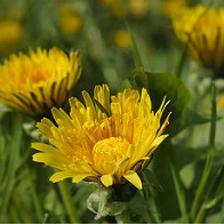

In [46]:
p=223
print(id_to_name[p])
image_embeddings.knn.display_picture(f"{home}/my_tf_flower", id_to_name[p])
results = image_embeddings.knn.search(index, id_to_name, embeddings[p])
image_embeddings.knn.display_results(f"{home}/my_tf_flower", results)

## Combination of images ?

Any vector in the same space can be used as query
For example I could have 2 image and want to find some example that are closeby to the 2, 
Let's just average them and see that happens !

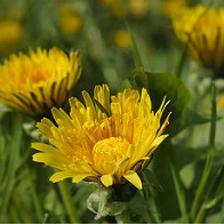

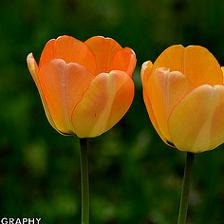

In [47]:
image1 = "image_dandelion_377"
image2 = "image_tulips_55"
p1 = name_to_id[image1]
p2 = name_to_id[image2]
image_embeddings.knn.display_picture(f"{home}/my_tf_flower", image1)
image_embeddings.knn.display_picture(f"{home}/my_tf_flower", image2)
results = image_embeddings.knn.search(index, id_to_name, (embeddings[p1] + embeddings[p2])/2)
image_embeddings.knn.display_results(f"{home}/my_tf_flower", results)

As expected we see a mixture of images that look like both

## Next ?

What else can you build with this ?

An obvious example is retrieval (looking for closeby pictures) but recommendation systems or photo managers can also work very well using image embeddings !